# ICE 1: K-Means Clustering

## Pre-reading

- [Scikit-learn Clustering](https://scikit-learn.org/stable/modules/clustering.html) sections `2.3.1` and `2.3.2`

![K-Means Clustering](https://imgs.xkcd.com/comics/k_means_clustering.png)

*According to my especially unsupervised K-means clustering algorithm, there are currently about 8 billion types of people in the world.*


### Goals

- Learn to import and load scikit-learn datasets into numpy arrays
- Use [KMeans](https://scikit-learn.org/stable/modules/clustering.html#k-means) to conduct unsupervised learning
- Explore the impact of initialization and iterations
- Explore a mismatch of `K` and the number of classes

This lab is modified from the [Scikit Learn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html).

## Load and explore the dataset

In [2]:
# Google colab includes these by default, so you won't need to run
%pip install -q scikit-learn matplotlib

We will start by loading the [iris](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) dataset.
This dataset contains measurements from the Iris-Setosa, Iris-Versicolour, and Iris-Virginica flowers.

Each sample in the dataset contains the following measurements, in centimeters:

- sepal length
- sepal width
- petal length
- petal width

In the context of clustering, we would like to classify the type of iris based on the measurements of its sepal and petals.

*An Iris Setosa*

![Iris Setosa](https://live.staticflickr.com/65535/51376589362_b92e27ae7a_b.jpg)

In [24]:
import numpy as np
from sklearn.datasets import load_digits

# Load the dataset
data, labels = load_digits(return_X_y=True)
n_classes = np.unique(labels).size
n_samples, n_features = data.shape

print(
    f"# classes: {n_classes}; # samples: {n_samples}; # features per sample: {n_features}"
)

# classes: 10; # samples: 1797; # features per sample: 64


Notice that the `load_iris` method returns a tuple, the first element of which is the **data**, the second of which is the **labels**.

You can print the numpy array's shape and values.

In [25]:
print(f"Shape of numpy data array: {data.shape}")
print("Raw data...")
print(data)

Shape of numpy data array: (1797, 64)
Raw data...
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


Run this a few times to select and view a random sample from the dataset.

In [26]:
from random import randrange

sample_id = randrange(n_samples)
sample = data[sample_id]

# Numpy doesn't contain headers, so extract features via index
print(
    f"""Sample {sample_id}:
      sepal length = {sample[0]}
      sepal width = {sample[1]}
      petal length = {sample[2]}
      petal width = {sample[3]}
      label = {labels[sample_id]}"""
)

# skip the part above ^

Sample 1320:
      sepal length = 0.0
      sepal width = 0.0
      petal length = 8.0
      petal width = 16.0
      label = 5


### Plot the data

#### 4D Plot

If we use color to represent the 4th dimension on a 3D plot, we can visualize our data.

In [14]:
# The percent sign runs a terminal command in the current virtual environment
# In this case, just help display charts more nicely in the notebook.
%matplotlib inline

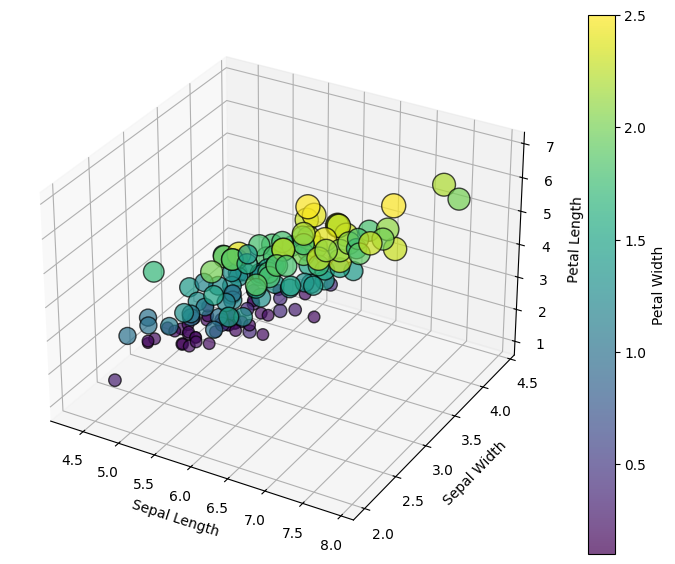

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Use sepal length, sepal width, petal length for x, y, z axes
x = data[:, 0]  # Sepal length
y = data[:, 1]  # Sepal width
z = data[:, 2]  # Petal length

# Use petal width as the fourth dimension, represented by color or size
c = data[:, 3]  # Petal width

markers = ["o", "^", "s"]  # 'o' for setosa, '^' for versicolor, 's' for virginica

# Plot the points, with petal width affecting the color and size
scatter = ax.scatter(
    x, y, z, c=c, cmap="viridis", s=50 + c * 100, edgecolor="k", alpha=0.7
)

# Add labels
ax.set_xlabel("Sepal Length")
ax.set_ylabel("Sepal Width")
ax.set_zlabel("Petal Length")
fig.colorbar(scatter, ax=ax, label="Petal Width")

# Show the plot
plt.show()

We can definitely see some possible clusters, but nothing that we could really select by hand.
Honestly, this isn't very helpful.

#### PCA-reduced data

Do we even need all four of those measurements??

Principal Component Analysis (PCA) is a dimensionality reduction technique who's goal is to reduce the number of features in a dataset while retaining as much variance (information) as possible.

The Covariance/ Eigenvector/ Transform of PCA is beyond the scope of this course (try ECE 487!).

Just know that the final result is a set of new dimensions that are linear combinations of the original dimensions.

For this lab we will use [sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
to accomplish the feature reduction. Then we will plot the samples in this new 2D space.

Notice that we get two very clear clusters! But we have three classes of flowers..
We will add color that matches the labels **but** that's only because we happen to know the labels.
K-means is an *unsupervised* algorithm, meaning it works on datasets even if the labels aren't known!

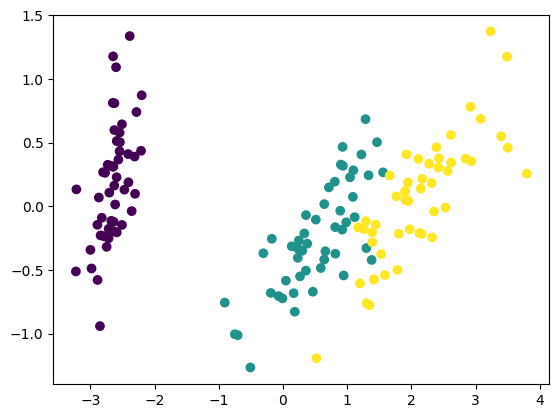

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# reduce the 64-dimension data to 2-D
pca_data = PCA(n_components=2).fit_transform(data)
# simple, non-fancy plot
# plt.plot(pca_data[:, 0], pca_data[:, 1], "k.", markersize=2)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels)

## Iterate with K-Means

First, we'll define a method `plot_kmeans` that will add color, centroids, and lines to our PCA plot.

In [17]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_kmeans(reduced_data, kmeans, iteration):
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Clear previous plot
    clear_output(wait=True)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.scatter(pca_data[:, 0], pca_data[:, 1], s=4, c=labels)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(
        "K-means clustering on the digits dataset (PCA-reduced data)\n"
        "Centroids are marked with white cross\n"
        "Iteration: {}".format(iteration)
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

### Step through kmeans

Before we use the builtin fit method, let's step through what the algorithm is doing. We will do this with [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html).

This first code block randomly picks centroids and then runs k-means once before plotting.

The white **X**'s are the randomly selected centroids of each cluster.
Because we didn't specify `random_state` as the seed within `MiniBatchKMeans` this will be different every time we run it.
Sometimes that results in better convergence than others!

The next code cell does a few iterations, each moving the centroids closer to the center of the nearest cluster.

*Run these code blocks a few times to see some different outcomes!* Do you see any instances where the centroids converge on a local minimum that's clearly wrong?

Again, remember that k-means doesn't know about the true labels because it's an unsupervised algoritihm.

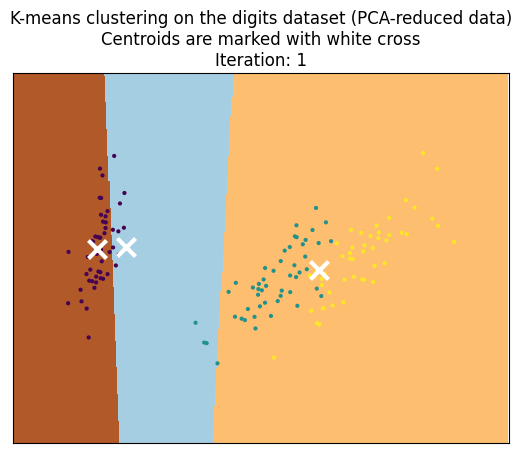

In [18]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from time import sleep


# PCA reduction to 2D
reduced_data = PCA(n_components=2).fit_transform(data)

# initialize
kmeans_step = MiniBatchKMeans(
    n_clusters=n_classes, init="random", n_init=1, batch_size=10, max_iter=1
)

kmeans_step.partial_fit(reduced_data)

# dispaly clusters
plot_kmeans(reduced_data, kmeans_step, 1)

In [ ]:
max_iterations = 16
step_size = 1
for i in range(0, max_iterations, step_size):
    # step_size iterations between plots
    for k in range(step_size):
        kmeans_step.partial_fit(reduced_data)

    plot_kmeans(reduced_data, kmeans_step, i)
    sleep(0.05)

plot_kmeans(reduced_data, kmeans_step, max_iterations)

## Actual Fit

Enough playing around! Let's actually fit the clusters. We'll do the following to help address some issues observed above.

1. Instead of specifying the number of iterations, use the [fit](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.fit)
    method to automatically stop when the algorithm **converges**.
    This is defined as there being no meaningful change of the centroid locations between rounds.
2. Define and employ benchmarks.
3. Use `k-means++` to initialize the centroids to be distant from each other.
4. Run the algorithm multiple times to compare the random initializations.

### Define our evaluation benchmark

Our benchmark will:

- create a pipeline which will scale the data using a [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html);
- train and time the pipeline fitting;
- measure clustering performance via metrics from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).

We will use the following metrics:

- **Homogeneity Score** is maximized if clusters contain only data points which are members of a single class.
- **Completeness Score** is maximized if all the data points that are members of a given class are elements of the same cluster.
- **V-measure** is the harmonic mean between homogeneity and completeness, and ultimately what we care about most here.

In [ ]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time]

    # Define the metrics which require only the true labels and estimator labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
    ]

    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # Show the results
    formatter_result = "{:9s}\t{:.3f}s\t{:.3f}\t{:.3f}\t{:.3f}"
    print(formatter_result.format(*results))

### Run the benchmark

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Load a fresh copy of the dataset
data, labels = load_iris(return_X_y=True)
n_classes = 3  # three types of flowers
n_samples, n_features = data.shape

print(
    f"# classes: {n_classes}; # samples: {n_samples}; # features per sample: {n_features}"
)

print("Results for Iris Dataset:")
print(f"# classes: {n_classes}; # samples: {n_samples}; # features {n_features}")

# top bar of stats
print("Results for", n_classes, "clusters")
print(58 * "_")
print("init\t\ttime\thomo\tcompl\tv-meas")

# Initialize a K-means algorithm and try on original data
kmeans = KMeans(init="k-means++", n_clusters=n_classes, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="Original", data=data, labels=labels)

# Initialize a fresh K-means algorithm and try on PCA data

pca_n_components = 2  # 2 is default because we like x-y charts, but...

kmeans_pca = KMeans(init="k-means++", n_clusters=n_classes, n_init=4, random_state=0)
reduced_data = PCA(n_components=pca_n_components).fit_transform(data)
bench_k_means(
    kmeans=kmeans_pca, name=f"PCA-{pca_n_components}", data=reduced_data, labels=labels
)

# bottom bar of stats
print(58 * "_")

### Predict

Now that we have a fit model, let's make a prediction on a sample!

We will use the builtin [predict](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.predict) method and the results of our PCA-based kmeans model.

Because this is an unsupervised clustering algorithm, the clusters number from our true labels probably don't match the ones that kmeans produces!

The code below only works with two PCA components and `random_state=0` above; if you change that you'll need to re-match te labels yourself.

In [19]:
new_labels = np.zeros_like(labels)

for i in range(n_samples):
    if labels[i] == 0:
        new_labels[i] = 2
    elif labels[i] == 1:
        new_labels[i] = 0
    else:
        new_labels[i] = 1

In [20]:
# Get a random sample
sample_id = randrange(n_samples)

# Reshape because we are only predicting on a single sample, but KMeans expects a 2D array
sample = reduced_data[sample_id].reshape(1, -1)
prediction = kmeans_pca.predict(sample).item()
print(f"PCA Kmeans prediction for sample {sample_id}: {prediction}")
print(f"Correct label for sample {sample_id}: {new_labels[sample_id]}")

NameError: name 'kmeans_pca' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Make predictions for the entire set of samples
all_predictions = kmeans_pca.predict(reduced_data)

# Confusion matrix
confusion = confusion_matrix(new_labels, all_predictions)
print("Confusion matrix:")
print(confusion)

accuracy = accuracy_score(all_predictions, new_labels)
print(f"Overall accuracy: {accuracy}")

## ICE Deliverables

Now that you have k-means working on super simple dataset, let's try one slightly more complicated!

1. Use [load_digits](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset) to get a dataset of handwritten digits.
2. Using the same `bench_k_means` function from above, fit a kmeans with no PCA (hint, pay attention to the number of clusters).
3. Using the same `bench_k_means` function from above, fit PCA with [2, 8, 16, 32, 64] components.
4. Answer the questions on Gradescope for this ICE.

In [28]:
# Google colab includes these by default, so you won't need to run
%pip install -q scikit-learn matplotlib

import numpy as np
from sklearn.datasets import load_digits

# Load the dataset
data, labels = load_digits(return_X_y=True)
n_classes = np.unique(labels).size
n_samples, n_features = data.shape

print(
    f"# classes: {n_classes}; # samples: {n_samples}; # features per sample: {n_features}"
)

# classes: 10; # samples: 1797; # features per sample: 64
